In [1]:
import os
import numpy as np
from PIL import Image

def load_and_preprocess_data(image_dir, mask_dir, img_size=(512, 512)):
    images = []
    masks = []
    
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)
        
        try:
          
            img = Image.open(img_path)
            img = img.convert('RGB')  
            img = img.resize(img_size)
            img = np.array(img)
            
            mask = Image.open(mask_path)
            mask = mask.convert('RGB')  
            mask = mask.resize(img_size)
            mask = np.array(mask)
            
            binary_mask = np.all(mask == (0, 0, 255), axis=-1).astype(np.uint8)
            
            images.append(img)
            masks.append(binary_mask)
        
        except Exception as e:
            print(f"Error processing {img_file} or {mask_file}: {e}")
    
    return np.array(images), np.expand_dims(np.array(masks), axis=-1)


In [ ]:
image_dir = 'X_images'   
mask_dir = 'Y_train'    

In [ ]:
x, y = load_and_preprocess_data(image_dir, mask_dir)

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
trainx, testx, trainy, testy = train_test_split(x, y, train_size = 0.8)

In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

x_in = Input(shape=(512, 512, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x_skip1)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x_skip2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x_skip2)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x_skip3 = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x_skip3)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2DTranspose(256, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Concatenate()([x, x_skip3])

x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Concatenate()([x, x_skip2])

x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Concatenate()([x, x_skip1])

x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.summary()

model.fit(trainx, trainy, epochs=10, batch_size=5, validation_split=0.1)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
prediction = model.predict(testx[0:5])

1/1 [==============================] - 0s 24ms/step


In [7]:
from matplotlib.pyplot import imshow

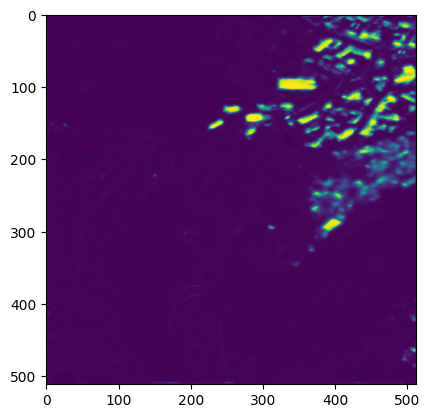

In [11]:
imshow(prediction[1])

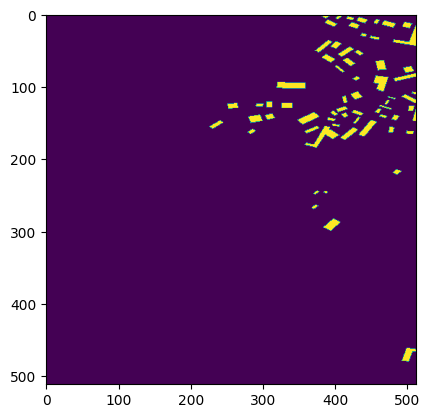

In [12]:
imshow(testy[1])